In [ ]:
import pandas as pd
df = pd.read_csv("../Data/df_score_as_value.tsv", sep="\t", index_col=0)

In [4]:
# df: your original Open Targets DataFrame (genes x diseases)

# Step 1: Compute the sum of scores across all diseases for each gene
gene_totals = df.sum(axis=1, skipna=True)

# Step 2: Normalize each value by the corresponding gene's total
normalized_df = df.div(gene_totals, axis=0)

# (Optional) If you want to fill NaNs with 0 (e.g., for ranking):
normalized_df = normalized_df.fillna(0)

EMD and wmra


In [104]:
import pandas as pd
METHOD = "unidirectional_multilayer_rwr"
FOLDER1 = "HEART_FAILURE"
disease = "heart failure"
hypergraph1_result_df = pd.read_csv(f"../Methods/output/DGIDB_{FOLDER1}/{METHOD}_results.csv")


In [105]:
print(normalized_df[disease])

geneCommonName
7SK         0.000000
A1BG        0.000000
A1BG-AS1    0.000000
A1CF        0.000441
A2M         0.000652
              ...   
ZYG11A      0.000000
ZYG11B      0.000000
ZYX         0.000000
ZZEF1       0.000000
ZZZ3        0.000000
Name: heart failure, Length: 25307, dtype: float64


In [106]:
print(hypergraph1_result_df["claim_name"])

0          TGFB1
1          PRKCB
2          PTGS2
3            BAX
4           GJA1
          ...   
21976    ARPC3P3
21977    RPL31P4
21978     PFN1P1
21979     TUBA5P
21980    YWHAZP5
Name: claim_name, Length: 21981, dtype: object


In [107]:
filtered_df = df[df[disease].notna()]
filtered_df = filtered_df.sort_values(by=disease, ascending=False)
disease_gene_set = filtered_df[disease].index
print(filtered_df[disease])

geneCommonName
TTN      0.704424
AGTR1    0.613008
ACE      0.612676
ADRB3    0.609415
ADRB1    0.605211
           ...   
CD82     0.001478
RBM4     0.001478
RBM4B    0.001478
CD6      0.001478
LRIG1    0.001478
Name: heart failure, Length: 4578, dtype: float64


In [108]:
import rbo
import numpy as np
from scipy.stats import wasserstein_distance

def ranking_agreement_score(L1_scores: dict, L1_ranking: list, L2_ranking: list, k: int = None) -> float:
    if k is None:
        k = len(L2_ranking)
    
    total = 0
    # Assign proxy scores to L2 based on inverse rank (1-based)
    for idx, item in enumerate(L2_ranking[:k]):
        if item not in L1_scores:
            continue  # skip items not in L1
        
        score_L1 = L1_scores[L1_ranking[idx]]
        score_L2 = L1_scores[item] 

        if score_L1 == 0 or score_L2 == 0:
            continue  # avoid division by zero
        ratio = min(score_L2 / score_L1, score_L1 / score_L2)
        total += ratio

    return total / k
emd_scores = []
def gene_emd(scores: dict, comp: list, k) -> float:
    """
    Compute EMD between:
    - full distribution over top-k genes
    - masked distribution over the same top-k genes, only for `comp` genes
    """
    # Sort genes by score descending
    sorted_genes = sorted(scores.keys(), key=lambda g: scores[g], reverse=True)
    top_k_genes = sorted_genes[:k]
    # print(top_k_genes)
    pos = list(range(k))  # positions are just 0 to k-1

    # Full distribution over top-k
    w1 = np.array([scores[g] for g in top_k_genes], dtype=float)
    w1 /= w1.sum()

    # Masked distribution: only keep scores for comp, else 0
    w2 = np.array([scores[g] if g in scores else 0.0 for g in comp], dtype=float)
    if w2.sum() == 0:
        return -1 # or np.nan
    w2 /= w2.sum()

    return wasserstein_distance(pos, pos, u_weights=w1, v_weights=w2)
def weighted_jaccard(base_weights, pred_set):
    # Convert pred_set to weighted if needed, e.g., 1.0 for all
    pred_weights = {k: 1.0 for k in pred_set}

    all_keys = set(base_weights.keys()).union(pred_weights.keys())

    numerator = sum(min(base_weights.get(k, 0.0), pred_weights.get(k, 0.0)) for k in all_keys)
    denominator = sum(max(base_weights.get(k, 0.0), pred_weights.get(k, 0.0)) for k in all_keys)

    return numerator / denominator if denominator > 0 else 0.0
wmra_scores = []
jaccard_scores = []
def dcg_at_k(relevance, k):
    relevance = np.asfarray(relevance)[:k]
    if relevance.size == 0:
        return 0.0
    return np.sum((2**relevance - 1) / np.log2(np.arange(2, relevance.size + 2)))

def ndcg_at_k(y_true, y_pred, k):
    # Sort by predicted scores
    order = np.argsort(y_pred)[::-1]
    true_sorted_by_pred = np.take(y_true, order)

    # Ideal ranking (sorted by true relevance)
    ideal_order = np.argsort(y_true)[::-1]
    ideal_sorted = np.take(y_true, ideal_order)

    dcg = dcg_at_k(true_sorted_by_pred, k)
    idcg = dcg_at_k(ideal_sorted, k)
    return dcg / idcg if idcg > 0 else 0.0



ks = [10, 20, 50, 100, 500]
# Assuming BIPOLAR_BASELINE is a DataFrame with a 'claim_name' column
# baseline_claims = list(BIPOLAR_BASELINE['claim_name'])
ndcg_scores = []
normalized_wmra_socres = []
normalized_emd_scores = []
for k in ks:
    top_k_predictions = list(hypergraph1_result_df["claim_name"][:k])
    top_k_truth = list(disease_gene_set[:k])  # ground truth ranking
    # top_k_baseline = baseline_claims[:k]

    # ---- RBO (optional, if enabled) ----
    # rbo_score = rbo.RankingSimilarity(top_k_predictions, top_k_truth).rbo(p=p)

    # ---- WMRA ----
    WMRA = ranking_agreement_score(filtered_df[disease], filtered_df[disease].index, top_k_predictions, k)
    wmra_scores.append(WMRA)
    # NORMALIZED WMRA
    normalized_wmra = ranking_agreement_score(normalized_df[disease], normalized_df[disease].index, top_k_predictions, k)
    normalized_wmra_socres.append(normalized_wmra)
    # ---- Jaccard Index ----
    # set_pred = set(top_k_predictions)
    # set_base = set(top_k_baseline)
    # jaccard_index = weighted_jaccard(filtered_df[disease], set_pred)
    # jaccard_scores.append(jaccard_index)

    # ---- NDCG ----
    # Build y_true: OpenTargets relevance scores aligned to your predicted gene list
    y_true = [filtered_df[disease].get(gene, 0) for gene in top_k_predictions]
    


    ## EMD
    emd_score = gene_emd(filtered_df[disease], top_k_predictions, k)
    # print("TOPK", top_k_predictions)
    # print(filtered_df[disease].index)
    emd_scores.append(emd_score)

    ## Normalized EMD
    normal_emd_score = gene_emd(normalized_df[disease], top_k_predictions, k)
    normalized_emd_scores.append(normal_emd_score)
    # # Use a simple descending rank as y_pred if you just want to rank based on your predicted list order
    # y_pred = list(range(k, 0, -1))

    # ndcg = ndcg_at_k(y_true, y_pred, k)
    # ndcg_scores.append(ndcg)

# Print all scores at the end
print("WMRA scores by k:")
for k, wmra in zip(ks, wmra_scores):
    print(f"@{k}: WRA = {wmra:.4f}")
print("\nNormalized WRA scores by k:")
for k, wmra in zip(ks, normalized_wmra_socres):
    print(f"@{k}: N-WRA = {wmra:.4f}")
print("\nEMD scores by k:")
for k, emd in zip(ks, emd_scores):
    print(f"@{k}: EMD = {emd:.4f}")
print("\nNORMALIZED EMD scores by k:")
for k, emd in zip(ks, normalized_emd_scores):
    print(f"@{k}: N-EMD = {emd:.4f}")


WMRA scores by k:
@10: WRA = 0.0932
@20: WRA = 0.1685
@50: WRA = 0.1502
@100: WRA = 0.1587
@500: WRA = 0.0743

Normalized WRA scores by k:
@10: N-WRA = 0.1885
@20: N-WRA = 0.0943
@50: N-WRA = 0.0526
@100: N-WRA = 0.0769
@500: N-WRA = 0.0342

EMD scores by k:
@10: EMD = 1.3782
@20: EMD = 1.7624
@50: EMD = 1.8510
@100: EMD = 8.3621
@500: EMD = 39.9464

NORMALIZED EMD scores by k:
@10: N-EMD = 0.5715
@20: N-EMD = 3.6156
@50: N-EMD = 7.7247
@100: N-EMD = 34.1386
@500: N-EMD = 33.0297


In [109]:
import os

parent_folder = "../Methods/output/"  # replace with your path

subfolders = [name for name in os.listdir(parent_folder)
              if os.path.isdir(os.path.join(parent_folder, name))]

subfolders = [
    name.replace("DGIDB_", "") 
    for name in os.listdir(parent_folder)
    if os.path.isdir(os.path.join(parent_folder, name)) and name.startswith("DGIDB_")
]

print(subfolders)

['', 'AIRWAY_HYPERREACTIVITY', 'ARTHRITIS', 'BIPOLAR', 'BREAST_CANCER', 'CROHNS', 'DIABETES_II', 'FULL', 'HEART_FAILURE', 'HIV', 'NEOPLASM_BREAST', 'SCHIZOPHRENIA']


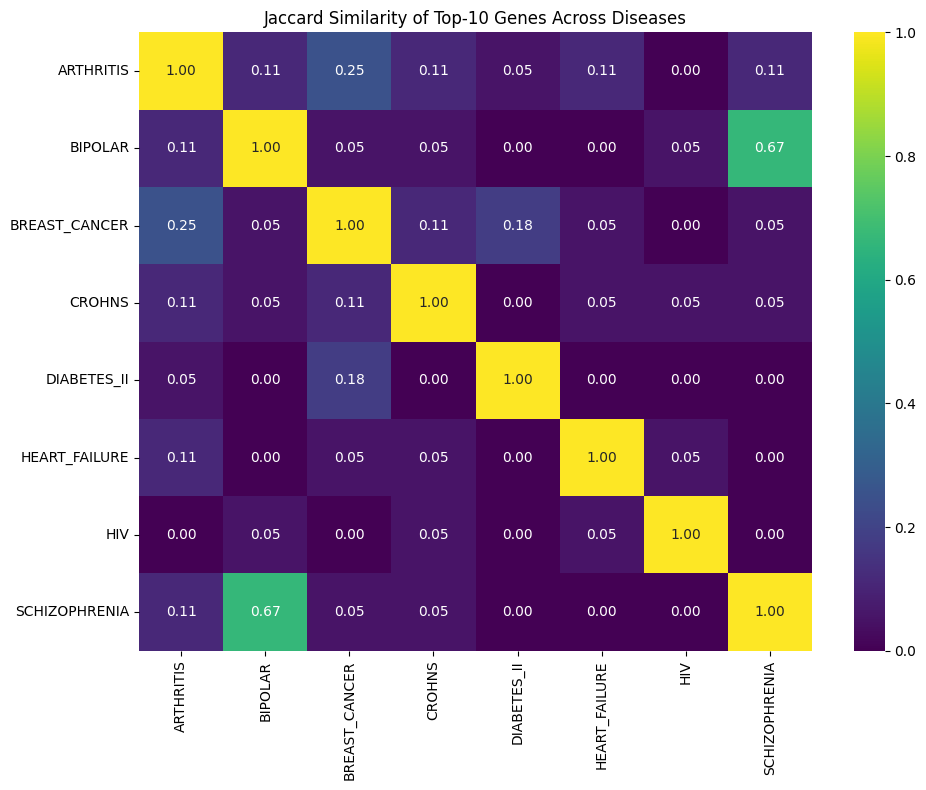

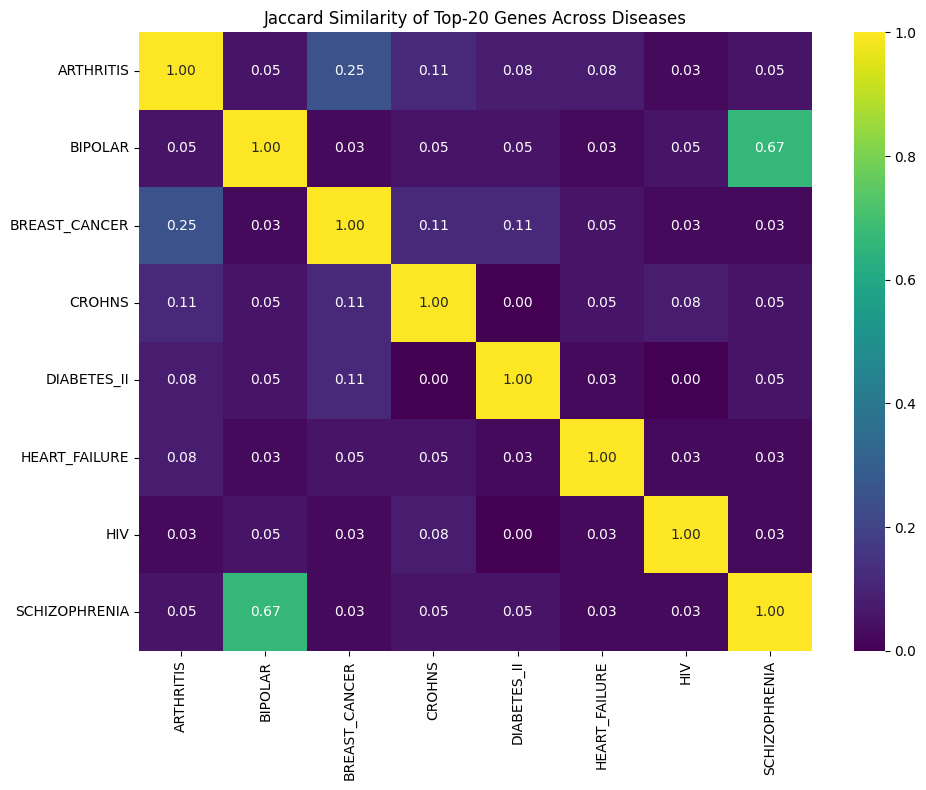

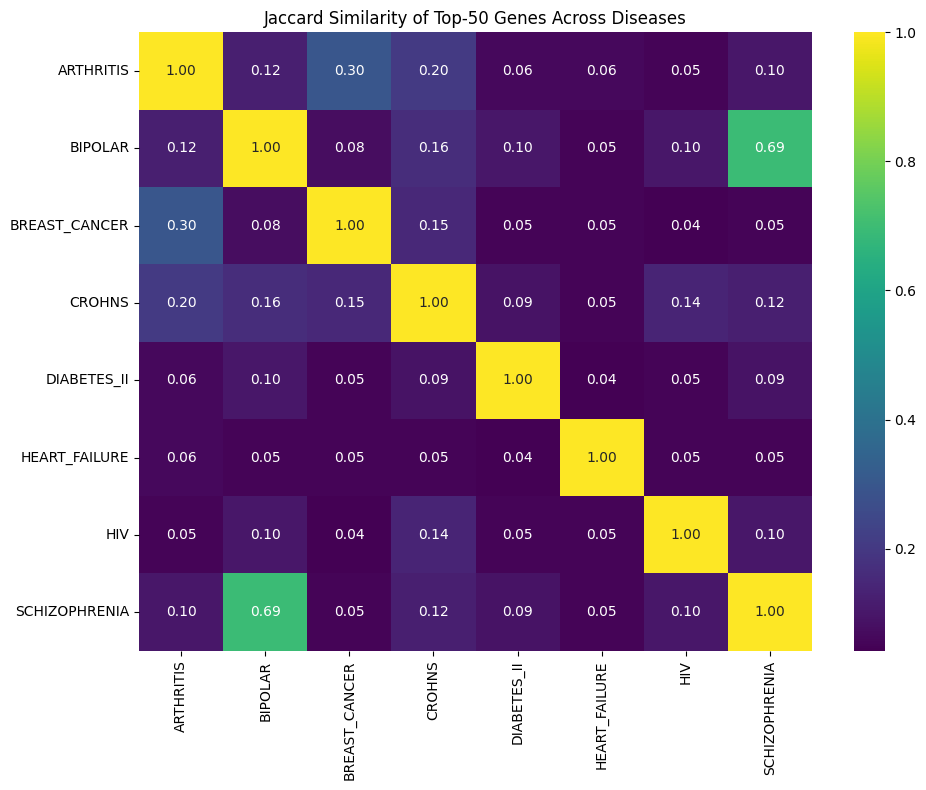

In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

def weighted_jaccard(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

disease_list = ['ARTHRITIS', 'BIPOLAR', 'BREAST_CANCER', 'CROHNS', 'DIABETES_II', 'HEART_FAILURE', 'HIV', 'SCHIZOPHRENIA']

ks = [10, 20, 50]
METHOD = 'unidirectional_multilayer_rwr'  # or whatever your method is called

# Dictionary to hold similarity matrices for each k
jaccard_matrices = {k: pd.DataFrame(index=disease_list, columns=disease_list) for k in ks}

# Iterate over all disease pairs (symmetric)
for disease1, disease2 in combinations_with_replacement(disease_list, 2):
    try:
        df1 = pd.read_csv(f"../Methods/output/DGIDB_{disease1}/{METHOD}_results.csv")
        df2 = pd.read_csv(f"../Methods/output/DGIDB_{disease2}/{METHOD}_results.csv")
        # Top predictions for each disease
        for k in ks:
            top_k_1 = set(df1['claim_name'].head(k))
            top_k_2 = set(df2['claim_name'].head(k))
            score = weighted_jaccard(top_k_1, top_k_2)

            # Fill both [i][j] and [j][i] due to symmetry
            jaccard_matrices[k].loc[disease1, disease2] = score
            jaccard_matrices[k].loc[disease2, disease1] = score

    except FileNotFoundError as e:
        print(f"Missing file for {disease1} or {disease2}: {e}")

# Optional: convert all values to float
for k in ks:
    jaccard_matrices[k] = jaccard_matrices[k].astype(float)

# 🔥 Plot heatmaps
for k in ks:
    plt.figure(figsize=(10, 8))
    sns.heatmap(jaccard_matrices[k], annot=True, cmap='viridis', fmt=".2f")
    plt.title(f'Jaccard Similarity of Top-{k} Genes Across Diseases')
    plt.tight_layout()
    plt.savefig(f"heatmap_top{k}.png")
    plt.show()
